<a href="https://colab.research.google.com/github/annykay/AppliedStatistics/blob/main/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
import numpy as np
import scipy
import scipy.stats

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm

## Task 1: Bayesian inference with MCMC

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [284]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
N = 20

prior_mu = 0.
prior_std = 1.

X = np.random.normal(true_mu, true_std, 20)

### Task 1.1: implement analytical posterior (1 point)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

In [398]:
def analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    
    n = len(samples)
    sigma_p = (1/sigma_0**2 + n/sigma**2)**(-1)
    mu_p = sigma_p*(mu_0/sigma_0**2 + sum(x)/sigma**2)
    print(mu_p)
    
    return scipy.stats.norm(mu_p, sigma_p**(1/2)).pdf(x) #sigma_p, mu_p

Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

In [399]:
post = analytical_posterior_pdf(X, X, X.std(), prior_mu, prior_std)
post_pred = scipy.stats.norm(X[np.argmax(post)], X.std()).pdf(X)
true_data = scipy.stats.norm(true_mu, true_std).pdf(X)

2.9727779404128185


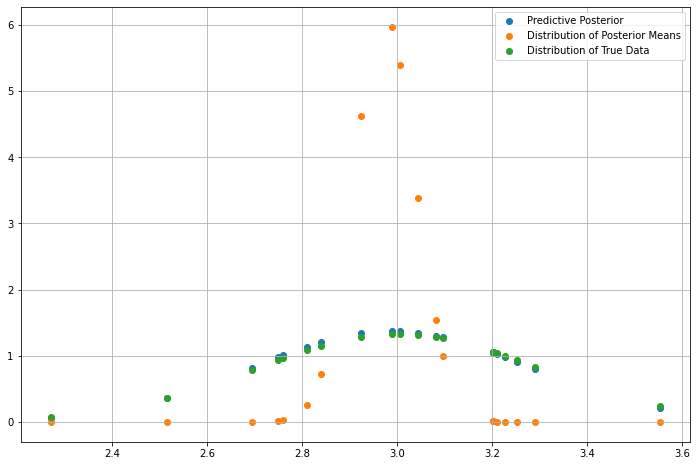

In [305]:
plt.figure(figsize=(12, 8))
plt.scatter(X, post_pred, label = "Predictive Posterior")
plt.scatter(X, post, label = "Distribution of Posterior Means")
plt.scatter(X, true_data, label = "Distribution of True Data")
plt.legend()
plt.grid(True)

### Task 1.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate it using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ form 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

Your task is to implement these steps, including the calculation of the acceptance probability, and run the chain. Numpy array `Y` should contain one MCMC trajectory that you have obtained as the result.

*You may need to tune the $\sigma_{step}$ parameter.

In [306]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """
    #sigma /= np.sqrt(len(samples))
    num = np.prod(scipy.stats.norm(y_new, sigma).pdf(samples))*scipy.stats.norm(mu_0, sigma_0).pdf(y_new)
    denom = np.prod(scipy.stats.norm(y_old, sigma).pdf(samples))*scipy.stats.norm(mu_0, sigma_0).pdf(y_old)
    
    r = num/denom
    p = min(1, r)
    return p

In [307]:
T = 1000
sigma_step = 0.15
Y = np.empty(T)
Y[0] = np.random.normal(prior_mu, prior_std)
acc = np.zeros(T)
acc[0] = 1

for i in tqdm(range(1, T)):
    # Your code here
    Z = scipy.stats.norm(0, sigma_step).rvs(size=1)[0]
    Y_next = Y[i-1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i-1], X, X.std(), Y[i-1], true_std):
        Y[i] = Y_next
        acc[i]= 1
    else:
        Y[i] = Y[i-1]
    pass

  0%|          | 0/999 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


### Task 1.3: Visualize the results (1 point)
We have obtained a single trajectory of our Markov chain. The tsarting portion the obtained values may be different from the samples of the actual posterinir. After the so-called 'burn-in' or 'warmup' phase the distribution should become stationary and connverge to the true posterior. Time spent before this convergence occurs is usually called *mixing time*, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

3. When do you think the 'mixing' occured? (Approximately)

In [ ]:
# Your code here

Text(0, 0.5, 'Value of Mu at Each Step')

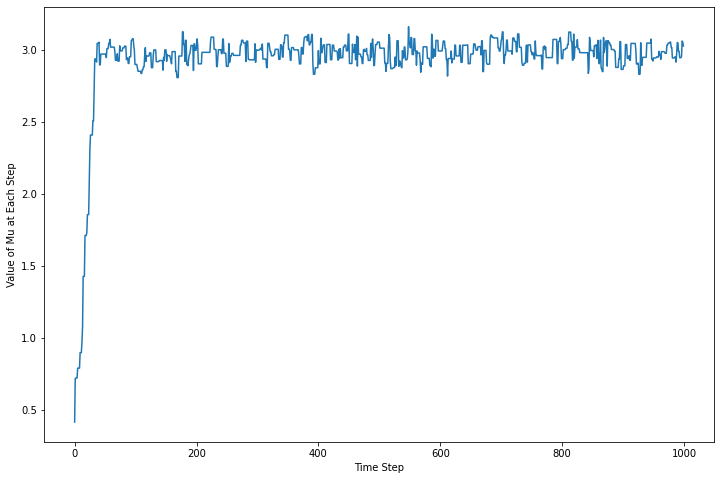

In [311]:
plt.figure(figsize=(12, 8))
plt.plot([i for i in range(len(Y))], Y ) 
plt.xlabel("Time Step")
plt.ylabel("Value of Mu at Each Step")

Text(0, 0.5, 'Value of Acceptance Probability at Each Step')

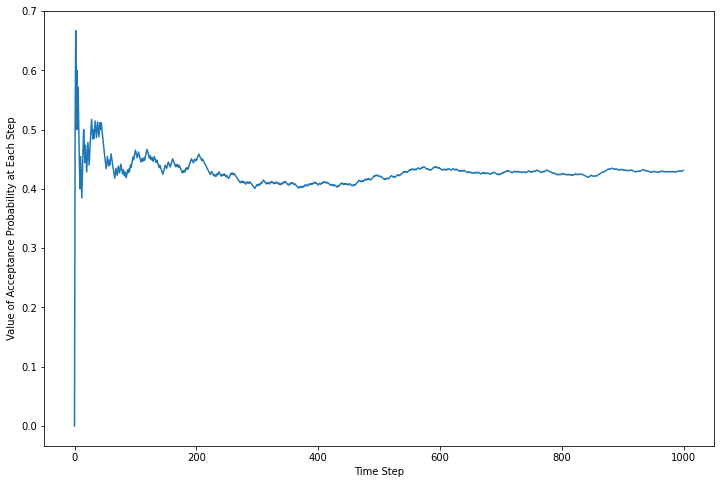

In [312]:
plt.figure(figsize=(12, 8))
plt.plot([i for i in range(len(Y))], [sum(acc[:i])/(i+1) for i in range(len(acc))] ) 
plt.xlabel("Time Step")
plt.ylabel("Value of Acceptance Probability at Each Step")

I tried to tune sigma_step to make acceptance probability close to 0,5. This probability changes over the time, but at the end become stational. 

### Task 1.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converged to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

In [317]:
Y_stat = Y[:500]
Y_third = np.array([Y_stat[i] for i in range(0, len(Y_stat), 3)])
Y_quater = np.array([Y_stat[i] for i in range(0, len(Y_stat),4)])

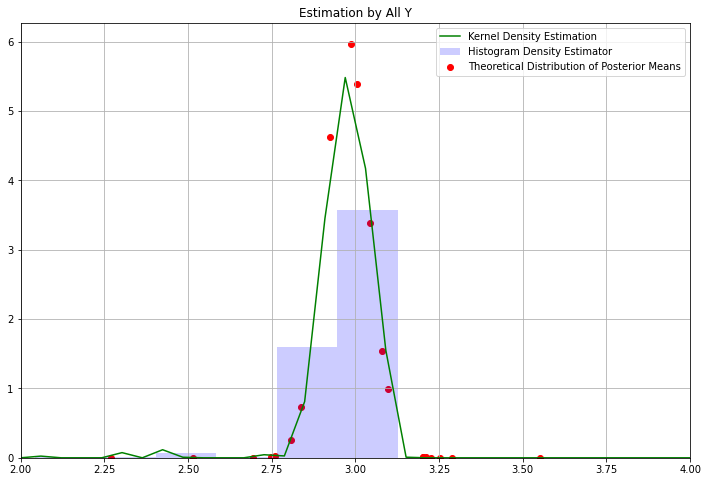

In [374]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Y_stat.reshape((-1,1)))

X_plot = np.linspace(0, 6, 100)

log_density = kde.score_samples(X_plot.reshape(-1,1))
plt.figure(figsize=(12, 8))
plt.hist(Y_stat, alpha = 0.2, bins = 15, label = "Histogram Density Estimator", color = 'b', density=True)
plt.plot(X_plot, np.exp(log_density), label = "Kernel Density Estimation", color = 'g')
plt.scatter(X, post, label = "Theoretical Distribution of Posterior Means", color = 'r')

plt.xlim(2,4)
plt.title("Estimation by All Y")
plt.legend()
plt.grid(True)

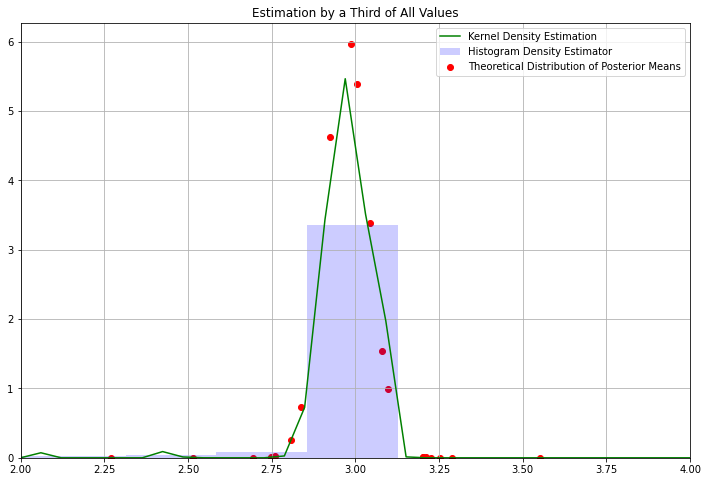

In [375]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Y_third.reshape((-1,1)))

X_plot = np.linspace(0, 6, 100)

log_density = kde.score_samples(X_plot.reshape(-1,1))
plt.figure(figsize=(12, 8))
plt.hist(Y_third, alpha = 0.2, label = "Histogram Density Estimator", color = 'b', density=True)
plt.plot(X_plot, np.exp(log_density), label = "Kernel Density Estimation", color = 'g')
plt.scatter(X, post, label = "Theoretical Distribution of Posterior Means", color = 'r')

plt.xlim(2,4)
plt.title("Estimation by a Third of All Values")
plt.legend()
plt.grid(True)

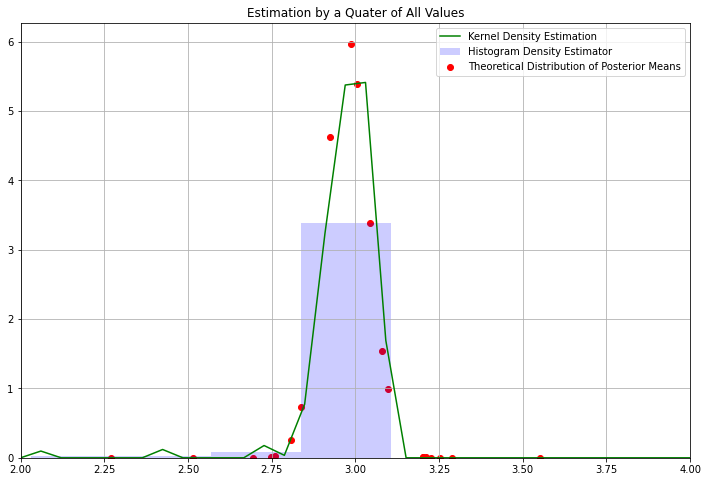

In [377]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(Y_quater.reshape((-1,1)))

X_plot = np.linspace(0, 6, 100)

log_density = kde.score_samples(X_plot.reshape(-1,1))
plt.figure(figsize=(12, 8))
plt.hist(Y_quater, alpha = 0.2, label = "Histogram Density Estimator", color = 'b', density=True)
plt.plot(X_plot, np.exp(log_density), label = "Kernel Density Estimation", color = 'g')
plt.scatter(X, post, label = "Theoretical Distribution of Posterior Means", color = 'r')

plt.xlim(2,4)

plt.title("Estimation by a Quater of All Values")
plt.legend()
plt.grid(True)

From here we can see, that kernel and histogram estimations become better after throwing away some values of Y. However, thay are still not very close to the theoretical one

### Task 1.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it in a Bayesian fashion, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

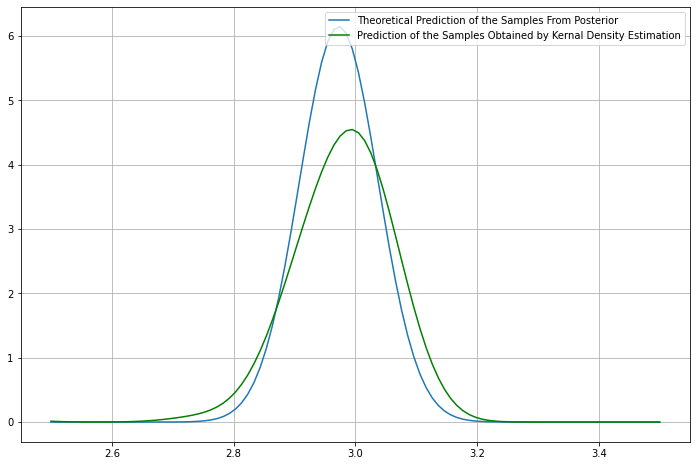

In [424]:
X_plot = np.linspace(2.5,3.5,100)
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(Y_quater.reshape((-1,1)))
log_density = kde.score_samples(X_plot.reshape(-1,1))
n = len(X)

sigma_p = (1/prior_std**2 + n/X.std()**2)**(-1)
mu_p = sigma_p*(prior_mu/prior_std**2 + sum(X)/X.std()**2)
post = scipy.stats.norm(mu_p, sigma_p**(1/2)).pdf(X_plot)
plt.figure(figsize=(12, 8))
plt.plot(X_plot, post, label = 'Theoretical Prediction of the Samples From Posterior')

plt.plot(X_plot, np.exp(log_density), label = "Prediction of the Samples Obtained by Kernal Density Estimation", color = 'g')
plt.legend()
plt.grid(True)

# Task 2. Substitution Cipher and Markov Chain Monte Carlo (MCMC). (5 points)

In this task we will decrypt data that was scrambled using a Substitution Cipher. We assume that encryption key is unknown and we want to decrypt the data and read the code using recovered decryption key. [Introduction from here](http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf) gives reference to the original task.

In [8]:
import string

As verification we will take a piece from "Alice's adventures in Wonderland". We scramble data with a random encryption key, which we forgot after encrypting, and we would like to decrypt this encrypted text using MCMC Chains.

In [9]:
plain_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.
"""

We will use 26 letters of English alphabet.

In [425]:
characters = string.ascii_lowercase
characters_dict = {char : c for c, char in enumerate(characters, start=1)}
m = len(characters) + 1

## Generate random encryption key.

Here are functions that will be used to encrypt/decrypt text.

In [426]:
def encode_text(text_to_encode, characters_dict):
    """This function turns a text string into an integer sequence using given dictionary."""
    characters_set = set(characters_dict.keys())
    return np.r_[[characters_dict[char] if char in characters_set else 0 for char in text_to_encode.strip().lower()]]

def decode_text(text_to_decode, characters):
    """This function turns an integer sequence into a text string using given list of characters."""
    characters_array = np.array([" "] + list(characters))
    return "".join(characters_array[text_to_decode])

def apply_cipher(text_as_int_array, cipher):
    "This function applies substitution cipher to an integer sequence."
    return cipher[text_as_int_array]

Generate encryption and decryption keys. They are just permutations of the alphabet.

In [427]:
np.random.seed(1234)

encryption_indices = np.random.permutation(np.arange(m-1))
decryption_indices = np.argsort(encryption_indices)

characters_array = np.array(list(characters))
encryption_key = "".join(characters_array[encryption_indices])
decryption_key = "".join(characters_array[decryption_indices])

Check encoding/decoding functions and encryption/decryption keys.

In [428]:
encryption_key_encoded = np.r_[0, encode_text(encryption_key, characters_dict)]
decryption_key_encoded = np.r_[0, encode_text(decryption_key, characters_dict)]

text = "The quick brown fox jumps over the lazy dog"

encoded_text = encode_text(text, characters_dict)
cipher_text = apply_cipher(encoded_text, encryption_key_encoded)
encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
decoded_text = decode_text(encoded_text, characters_dict)
decoded_text

'the quick brown fox jumps over the lazy dog'

Encrypt cipher text.

In [429]:
plain_text_encoded = encode_text(plain_text[:99], characters_dict)
cipher_text = apply_cipher(plain_text_encoded, encryption_key_encoded)

## Collect frequences 

Collect frequences of two character combinations (bigrams) over large text corpus and from encrypted text. We will store them in a matrix and interpret it as a transition matrix: from the first character to the second.

In [430]:
def collect_transition_frequences(data, transition_matrix):
    """For a given integer sequence, which corresponds to some char sequence, 
       return transitions for adjacent values."""
    transitions = data.repeat(2)[1:-1].reshape(-1, 2)
    for i, j in transitions:
        transition_matrix[i, j] += 1
    
    return transition_matrix

def collect_empirical_frequences(filename, characters_dict, m):
    """Collect frequences over large text corpus, return transition matrix."""
    transition_matrix = np.zeros((m, m))
    with open(filename) as f:
        for line in f:
            line_encoded = encode_text(line, characters_dict)
            if line_encoded.size > 1:
                transition_matrix = collect_transition_frequences(line_encoded, transition_matrix)
                
    return transition_matrix

def collect_observed_frequences(cipher_text, characters_dict, m):
    """Collect frequences over encrypted text, return nonzero indices of 
       transition matrix for both dimentions and values for those indices.
       `values = transition_matrix[indices_1, indices_2]`"""
    transition_matrix = np.zeros((m, m))
    transition_matrix = collect_transition_frequences(cipher_text, transition_matrix)
    
    return transition_matrix

Collect frequences.

In [431]:
empirical_frequences = collect_empirical_frequences('war_and_peace.txt', characters_dict, m)
observed_frequences = collect_observed_frequences(cipher_text, characters_dict, m)


In [432]:
# empirical_frequences = (empirical_frequences+1)/np.mean(empirical_frequences)
# observed_frequences = (observed_frequences+1)/np.mean(observed_frequences)

Our Chain will include states that are permutations of the substitution cipher. Algorithm has following steps:

1. Start by picking up a random current state. 
2. Create a proposal for a new state by swapping two or more random letters in the current state.
3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed state $Score_{new}$.
4. If the score of the proposed state is more than current state, Move to Proposed State.
5. Else flip a coin which has a probability of Heads $\frac{Score_{new}}{Score_{old}}$  . If it comes heads move to proposed State.
6. Repeat from Step 2.

We want ot reach a steady state where the chain has the stationary distribution of the needed states. This state of chain could be used as a solution.

Let's start with implementing steps 2 and 3.

## Step 2: Prepare sampling function (2 points).



To generate a new proposed cipher we randomly select several positions and swap values at those positions. It corresponds to change in seveal mappings of encrypted characters in decrypted ones. Example with 2 swaps.

was|now
-|-
A -> B | A -> B
B -> C | B -> C
C -> D | C -> A
D -> A | D -> D

In [433]:
import random

def generate_cipher(cipher, m, size=2):
    pos1 = np.array([random.randint(1, m-1) for i in range(size)])
    pos2 = np.array([random.randint(1, m-1) for i in range(size)])
    for i in range(size):
      if pos1[i] != pos2[i]:
        #cipher = list(cipher)
        pos1_alpha = cipher[pos1[i]]
        pos2_alpha = cipher[pos2[i]]
        cipher[pos1[i]] = pos2_alpha
        cipher[pos2[i]] = pos1_alpha

    return cipher

## Step 3: Prepare scoring function (2 points).

We want to use a scoring function for each state(Decryption key) which assigns a positive score to each decryption key. This score intuitively should be larger if the encrypted text looks more like actual english, when decrypted using this decryption key. We will check a large text and calculate frequences: how many times one character comes after another in a large text like "War and Peace".

For each pair of characters $\beta_1$ and $\beta_2$ (e.g. $\beta_1$ = A and $\beta_2$ = B), we let $R(\beta_1,\beta_2)$ record the number of times that specific pair(e.g. "AB") appears consecutively in the reference text.

Similarly, for a considered decryption key $x$, we let $F_x(\beta_1,\beta_2)$ record the number of times that
pair appears when the cipher text is decrypted using the decryption key $x$.

We then Score a particular decryption key $x$ using:

$$Score(x) = \prod R(\beta_1,\beta_2)^{F_x(\beta_1,\beta_2)}$$
    
To make life easier with calculations we will calculate $log(Score(x))$

Now, you need to implement scoring function. As input it takes 
- `cipher`: mapping between encrypted characters and decrypted characters,
- `observed_frequences`: transition matrix for cipher text, matrix representation of $F_x(\beta_1,\beta_2)$,
- `empirical_frequences`: transition matrix for large text, matrix representation of $R(\beta_1,\beta_2)$.

Scoring function returns $log(Score(x))$. You need correctly process zero values in transition matrices while calculating the score.

In [435]:
def score_cipher(cipher, observed_frequences, empirical_frequences):
    
    # decrypted_text = apply_cipher_on_text(cipher_text, cipher)
    # scored_f = score_params_on_cipher(decrypted_text)

    log_score = 0
    for i in range(len(cipher[1:])):
      for j in range(len(cipher[1:])):
        if empirical_frequences[i][j]!= 0:
          log_score += observed_frequences[cipher[i]][cipher[j]]*np.log(empirical_frequences[i][j])
    
    
    return log_score

## Decryption

Now we a ready to decrypt cipher text.

In [436]:
def decrypting(observed_frequences, empirical_frequences, n_iters, m, step_size, seed, print_it=1000):
    """This function finds most suited decrypting cipher(1D np.array).
        observed_frequences, 2D np.array - transition matrix with frequences for cipher text,
        empirical_frequences, 2D np.array - transition matrix with frequences for large text,
        n_iters, int - number of MCMC iterations,
        step_size, int - number of changes in cipher per one iteration,
        seed, int - seed for random generator,
        print_it, int - print decrypted text every `print_it` iterations.
    """

    np.random.seed(seed)

    # 1. Start by picking up a random current state. 
    cipher_old = np.arange(m)#np.array(sample([i for i in range(m)], m))
    cipher_old[5] = 2
    cipher_old[2] = 5
    #cipher_text = apply_cipher(plain_text_encoded, cipher_old)
    #observed_frequences_new = collect_observed_frequences(cipher_text, characters_dict, m)
    score_cipher_old = score_cipher(cipher_old, observed_frequences, empirical_frequences)
    best_state, score = cipher_old, score_cipher_old
    #state_keeper = set()
    

    for i in tqdm(range(1, n_iters+1)):
        #state_keeper.add(cipher_old)
        # 2. Create a proposal for a new state by swapping two or more random letters in the current state.
        cipher_new = generate_cipher(cipher_old, m, size=step_size)

        # 3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed State $Score_{new}$.
        #cipher_text = apply_cipher(plain_text_encoded, cipher_new)
        #observed_frequences_new = collect_observed_frequences(cipher_text, characters_dict, m)

        score_cipher_new = score_cipher(cipher_new, observed_frequences, empirical_frequences)
        acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))

        # 4. If the score of the proposed state is more than current state, Move to Proposed State.
        # 5. Else flip a coin which has a probability of Heads $Score_{new}/Score_{old}$. If it comes heads move to proposed State.
        if score_cipher_old > score:
            best_state, score = cipher_old, score_cipher_old
        if acceptance_probability > np.random.uniform(0,1):
            cipher_old, score_cipher_old = cipher_new, score_cipher_new
        if i % print_it == 0:
            print(f"iter {i}: {decode_text(apply_cipher(cipher_text[0:99], cipher_old), characters)}", score)


    return best_state


In [437]:
decrypt_cipher0 = decrypting(observed_frequences, empirical_frequences, 100000, m, 1, 345, 1000)

print(
    f"\nDecoded Text: {decode_text(apply_cipher(cipher_text, decrypt_cipher0), characters)}\n\n"
    f"MCMC KEY  : {''.join(characters_array[decrypt_cipher0[1:]-1])}\n"
    f"ACTual KEY: {decryption_key}"
)

  0%|          | 0/100000 [00:00<?, ?it/s]

iter 1000: wvzmr jwe trazsszsa yl ary qrfn yzfro lk ezyyzsa tn irf ezeyrf ls yir twsu  wso lk iwqzsa slyizsa 783.0974956502686
iter 2000: ntwoc bnz dciwyywyi ku ick fcgx kwgch ua zwkkwyi dx mcg zwzkcg uy kmc dnyq  nyh ua mnfwyi yukmwyi 787.1733206967151
iter 3000: kdygf vka efpyjjyjp qw pfq ofsi qysfx wz ayqqyjp ei ufs ayaqfs wj quf ekjt  kjx wz ukoyjp jwquyjp 787.1733206967151
iter 4000: bcufe wbz peyuttuty do yed lejx dujeg oa zudduty px hej zuzdej ot dhe pbtv  btg oa hbluty todhuty 787.1733206967151
iter 5000: fnohl vfw slgoiioig xt glx alcr xoclq tk woxxoig sr plc wowxlc ti xpl sfie  fiq tk pfaoig itxpoig 787.1733206967151
iter 6000: rztmo qrk sohtyytyh jp hoj aocd jtcoe pb ktjjtyh sd ioc ktkjoc py jio sryx  rye pb iratyh ypjityh 787.1733206967151
iter 7000: mcqxk zmp bklqnnqnl vg lkv ikjs vqjkw gh pqvvqnl bs rkj pqpvkj gn vrk bmny  mnw gh rmiqnl ngvrqnl 787.1733206967151
iter 8000: tlykx ztd exwyrryrw uj wxu pxvf uyvxg jq dyuuyrw ef hxv dyduxv jr uhx etrn  trg jq htpyrw rjuhyrw 78

As we can see here, the score stopped and don'tincrease any more. But the text doesn't look like normal englosh text. I tried to improve it, but was despaired. So I used code from towardsDataScience web site. 

In [438]:

import string
import math
import random

def create_cipher_dict(cipher):
    cipher_dict = {}
    alphabet_list = list(string.ascii_uppercase)
    for i in range(len(cipher)):
        cipher_dict[alphabet_list[i]] = cipher[i]
    return cipher_dict

# This function takes a text and applies the cipher/key on the text and returns text.
def apply_cipher_on_text(text,cipher):
    cipher_dict = create_cipher_dict(cipher) 
    text = list(text)
    newtext = ""
    for elem in text:
        if elem.upper() in cipher_dict:
            newtext+=cipher_dict[elem.upper()]
        else:
            newtext+=" "
    return newtext

In [439]:
# This function takes as input a path to a long text and creates scoring_params dict which contains the 
# number of time each pair of alphabet appears together
# Ex. {'AB':234,'TH':2343,'CD':23 ..}
def create_scoring_params_dict(longtext_path):
    scoring_params = {}
    alphabet_list = list(string.ascii_uppercase)
    with open(longtext_path) as fp:
        for line in fp:
            data = list(line.strip())
            for i in range(len(data)-1):
                alpha_i = data[i].upper()
                alpha_j = data[i+1].upper()
                if alpha_i not in alphabet_list and alpha_i != " ":
                    alpha_i = " "
                if alpha_j not in alphabet_list and alpha_j != " ":
                    alpha_j = " "
                key = alpha_i+alpha_j
                if key in scoring_params:
                    scoring_params[key]+=1
                else:
                    scoring_params[key]=1
    return scoring_params

# This function takes as input a text and creates scoring_params dict which contains the 
# number of time each pair of alphabet appears together
# Ex. {'AB':234,'TH':2343,'CD':23 ..}

def score_params_on_cipher(text):
    scoring_params = {}
    alphabet_list = list(string.ascii_uppercase)
    data = list(text.strip())
    for i in range(len(data)-1):
        alpha_i =data[i].upper()
        alpha_j = data[i+1].upper()
        if alpha_i not in alphabet_list and alpha_i != " ":
            alpha_i = " "
        if alpha_j not in alphabet_list and alpha_j != " ":
            alpha_j = " "
        key = alpha_i+alpha_j
        if key in scoring_params:
            scoring_params[key]+=1
        else:
            scoring_params[key]=1
    return scoring_params

# This function takes the text to be decrypted and a cipher to score the cipher.
# This function returns the log(score) metric

def get_cipher_score(text,cipher,scoring_params):
    cipher_dict = create_cipher_dict(cipher)
    decrypted_text = apply_cipher_on_text(text,cipher)
    scored_f = score_params_on_cipher(decrypted_text)
    #print(scored_f['EE'])
    cipher_score = 0
    for k,v in scored_f.items():
        if k in scoring_params:
            cipher_score += v*math.log(scoring_params[k])
    return cipher_score

In [446]:
# Generate a proposal cipher by swapping letters at two random location
def generate_cipher(cipher, size = 2):
    pos1 = [random.randint(0, len(list(cipher))-1) for i in range(size)]
    pos2 = [random.randint(0, len(list(cipher))-1) for i in range(size)]
    for i in range(size):
      if pos1[i] != pos2[i]:
        cipher = list(cipher)
        pos1_alpha = cipher[pos1[i]]
        pos2_alpha = cipher[pos2[i]]
        cipher[pos1[i]] = pos2_alpha
        cipher[pos2[i]] = pos1_alpha
    return "".join(cipher)

# Toss a random coin with robability of head p. If coin comes head return true else false.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

In [459]:
# Takes as input a text to decrypt and runs a MCMC algorithm for n_iter. Returns the state having maximum score and also
# the last few states 
def MCMC_decrypt(n_iter,cipher_text,scoring_params, size = 2):
    current_cipher = string.ascii_uppercase # Generate a random cipher to start
    state_keeper = list()
    best_state = ''
    score = 0
    scores = []
    for i in range(n_iter):
        
        proposed_cipher = generate_cipher(current_cipher, size = size)
        score_current_cipher = get_cipher_score(cipher_text,current_cipher,scoring_params)
        score_proposed_cipher = get_cipher_score(cipher_text,proposed_cipher,scoring_params)
        acceptance_probability = min(1,math.exp(score_proposed_cipher-score_current_cipher))
        if score_current_cipher>score:
            best_state = current_cipher
            score = score_current_cipher
        if random_coin(acceptance_probability):
            current_cipher = proposed_cipher
            scores.append(score_current_cipher)
            state_keeper.append(current_cipher)
        if i%500==0:
            print("iter",i,":",apply_cipher_on_text(cipher_text,current_cipher)[0:99], score_current_cipher)
    return state_keeper, best_state,scores

In [469]:
cipher_text = apply_cipher_on_text(plain_text[0:99],encryption_key)


scoring_params = create_scoring_params_dict('war_and_peace.txt')
print("Text To Decode:", cipher_text)
print("\n")
states,best_state,scores = MCMC_decrypt(80000,cipher_text,scoring_params, size=2)
print("\n")
print("Decoded Text:",apply_cipher_on_text(cipher_text,best_state))
print("\n")
print("MCMC KEY FOUND:",best_state)
print("ACTUAL DECRYPTION KEY:",decryption_key)

Text To Decode:  hxacb vhr qbfayyayf zw fbz mbjt zajbd ws razzayf qt ebj rarzbj wy zeb qhyn  hyd ws ehmayf ywzeayf 


iter 0 :  HNACB VHR QBIAYYAYI ZW IBZ MBJT ZAJBD WS RAZZAYI QT EBJ RARZBJ WY ZEB QHYX  HYD WS EHMAYI YWZEAYI  599.2666090733626
iter 500 :  AVEWI PAL BIOESSESO TR OIT GINM TENID RY LETTESO BM HIN LELTIN RS THI BASK  ASD RY HAGESO SRTHESO  901.4725016559688
iter 1000 :  ACEMI PAS WIYERRERY TO YIT VINL TENID OU SETTERY WL HIN SESTIN OR THI WARG  ARD OU HAVERY ROTHERY  926.2882578642469
iter 1500 :  ABEXI FAP WISERRERS TO SIT CINL TENID OU PETTERS WL HIN PEPTIN OR THI WARY  ARD OU HACERS ROTHERS  933.0119930741132
iter 2000 :  IVECA FIN WASERRERS TO SAT MALY TELAD OU NETTERS WY HAL NENTAL OR THA WIRK  IRD OU HIMERS ROTHERS  938.3889415177712
iter 2500 :  IKECA BIN WASERRERS TO SAT MALY TELAD OF NETTERS WY HAL NENTAL OR THA WIRG  IRD OF HIMERS ROTHERS  939.3827162528382
iter 3000 :  IMECA KIR WASENNENS TO SAT PALY TELAG OF RETTENS WY HAL RERTAL ON THA WIND  ING OF HIPENS NOT

here we can see, that the text becomes to look like normal english text. So 

In [466]:
states[np.argmax(scores)]


'IEMLHDKAXRJUCGQZBSFYPWOVNT'

In [468]:
max(scores)

962.9000205039301

## Tuning parameters (1 point).

For step sizes in range `[2, ..., 7]`(number of pertrubations in newly generated cipher) find number of iteratoins, with `..00` precision(`print_it=100`), which is necessary to make cipher text looks more like english one. Plot obtained results.

In [472]:
states = []
best_states = []
scores = []
for i in range(2,8):
  state,best_state,score = MCMC_decrypt(50000,cipher_text,scoring_params, size=i)
  states.append(state)
  best_states.append(best_state)
  scores.append(score)

iter 0 :  HXACI VHR QIFAYYAYF ZW FIZ MIJT ZAJID WS RAZZAYF QT EIJ RARZIJ WY ZEI QHYK  HYD WS EHMAYF YWZEAYF  599.2666090733626
iter 500 :  UNICE PUL BEOITTITO SA OES MEDY SIDEW AR LISSITO BY HED LILSED AT SHE BUTF  UTW AR HUMITO TASHITO  919.3421203702762
iter 1000 :  OFICE BOS REHITTITH MA HEM LEDY MIDEW AN SIMMITH RY PED SISMED AT MPE ROTU  OTW AN POLITH TAMPITH  925.0336843367668
iter 1500 :  OLICE BOM REHITTITH SA HES FEDY SIDEW AN MISSITH RY PED MIMSED AT SPE ROTU  OTW AN POFITH TASPITH  930.0031148645821
iter 2000 :  OUIPE CON BEHITTITH SA HES WEDG SIDER AY NISSITH BG MED NINSED AT SME BOTL  OTR AY MOWITH TASMITH  926.0749632619822
iter 2500 :  OPIGE MON BEHITTITH SA HES WEDU SIDER AY NISSITH BU LED NINSED AT SLE BOTF  OTR AY LOWITH TASLITH  928.938680257022
iter 3000 :  OVIKE LON FEHITTITH SA HES WEDU SIDER AY NISSITH FU CED NINSED AT SCE FOTM  OTR AY COWITH TASCITH  927.372708110641
iter 3500 :  OVIKE FON BEHITTITH SA HES WEDU SIDER AM NISSITH BU CED NINSED AT SCE BOTY  OTR AM 

KeyboardInterrupt: ignored

In [ ]:
# Your code here